In [2]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


epoch:   1 loss: 0.00067940
epoch:  26 loss: 0.00747634
epoch:  51 loss: 0.00857190
epoch:  76 loss: 0.01067001
epoch:  99 loss: 0.0000355934
RMSE:  8839.0784224446


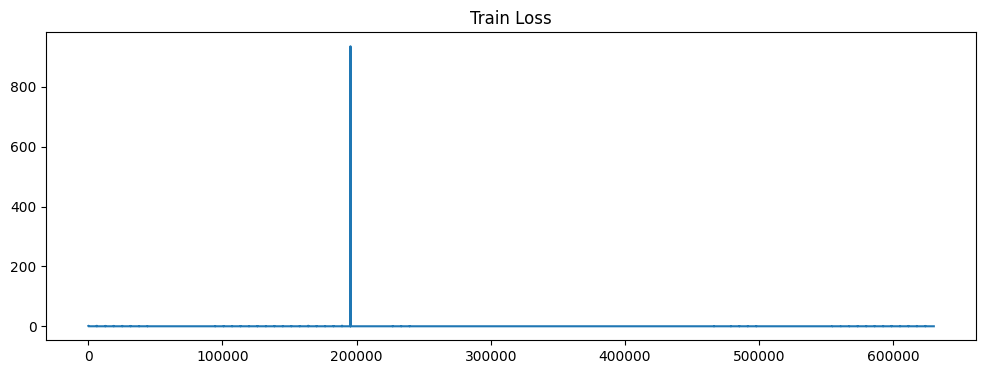

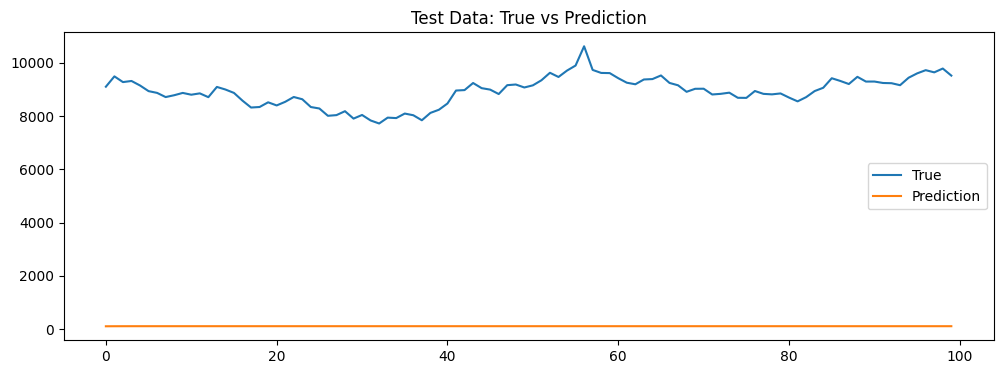

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
price = pd.read_csv('/content/AMZN.csv')
price = price['Close'].values.astype(float)

# Test, validation, and training splits
test_data_size = 100
valid_data_size = 100

train_data = price[:-2*test_data_size]
valid_data = price[-2*test_data_size:-test_data_size]
test_data = price[-test_data_size:]

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

# Convert to tensors
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1).to(device)
valid_data_normalized = scaler.transform(valid_data.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.reshape(-1, 1))

# Windowing
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 12
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

# Define model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size).to(device)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device),
                            torch.zeros(1,1,self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Training the model with optimized parameters
model = LSTM(input_size=1, hidden_layer_size=45, output_size=1).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.008675)
epochs = 100

train_losses = []
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        train_losses.append(single_loss.item())
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

# Predicting on test data
test_inputs = train_data_normalized[-train_window:].tolist()
model.eval()

for i in range(test_data_size):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())

actual_test_data = scaler.inverse_transform(np.array(test_data.reshape(-1, 1)))
predicted_test_data = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(actual_test_data, predicted_test_data))
print('RMSE: ', rmse)

# Plotting train losses
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_losses)), train_losses)
plt.title('Train Loss')
plt.show()

# Plotting actual vs predicted values
plt.figure(figsize=(12, 4))
plt.plot(actual_test_data, label='True')
plt.plot(predicted_test_data, label='Prediction')
plt.title('Test Data: True vs Prediction')
plt.legend()
plt.show()
